## Beginners Guide to Text Generation using LSTMs

Text Generation is a type of Language Modelling problem. Language Modelling is the core problem for a number of of natural language processing tasks such as speech to text, conversational system, and text summarization. A trained language model learns the likelihood of occurrence of a word based on the previous sequence of words used in the text. Language models can be operated at character level, n-gram level, sentence level or even paragraph level. In this notebook, I will explain how to create a language model for generating natural language text by implement and training state-of-the-art Recurrent Neural Network.

Generating News headlines
In this kernel, I will be using the dataset of New York Times Comments and Headlines to train a text generation language model which can be used to generate News Headlines

### 1. Import the libraries
As the first step, we need to import the required libraries:

In [1]:
# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 

# set seeds for reproducability
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(2)
seed(1)

import pandas as pd
import numpy as np
import string, os 

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


### 2. Load the dataset
Load the dataset of news headlines

In [2]:
curr_dir = './nyt-comments/'
all_headlines = []
for filename in os.listdir(curr_dir):
    if 'Articles' in filename:
        article_df = pd.read_csv(curr_dir + filename)
        all_headlines.extend(list(article_df.headline.values))
        break

all_headlines = [h for h in all_headlines if h != "Unknown"]
len(all_headlines)

831

Dataset cleaning
In dataset preparation step, we will first perform text cleaning of the data which includes removal of punctuations and lower casing all the words.

In [7]:
all_headlines

['Finding an Expansive View  of a Forgotten People in Niger',
 'And Now,  the Dreaded Trump Curse',
 'Venezuela’s Descent Into Dictatorship',
 'Stain Permeates Basketball Blue Blood',
 'Taking Things for Granted',
 'The Caged Beast Awakens',
 'An Ever-Unfolding Story',
 'O’Reilly Thrives as Settlements Add Up',
 'Mouse Infestation',
 'Divide in G.O.P. Now Threatens Trump Tax Plan',
 'Variety Puzzle: Acrostic',
 'They Can Hit a Ball 400 Feet. But Play Catch? That’s Tricky.',
 'In Trump Country, Shock at Trump Budget Cuts',
 'Why Is This Hate Different From All Other Hate?',
 'Pick Your Favorite Ethical Offender',
 'My Son’s Growing Black Pride',
 'Jerks and the Start-Ups They Ruin',
 'Trump  Needs  a Brain',
 'Manhood in the Age of Trump',
 'The Value of a Black College',
 'Initial Description',
 'Rough Estimates',
 'El Pasatiempo Nacional',
 'Cooling Off on a Hot Day at Yankee Stadium',
 'Trump’s Staff Mixed Politics and Paydays',
 'A Virtuoso Rebuilding Act Requires Everyone in Tune',

### 3. Dataset preparation
#### 3.1 Dataset cleaning
In dataset preparation step, we will first perform text cleaning of the data which includes removal of punctuations and lower casing all the words.

In [40]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

corpus = [clean_text(x) for x in all_headlines]
corpus[:10]

['finding an expansive view  of a forgotten people in niger',
 'and now  the dreaded trump curse',
 'venezuelas descent into dictatorship',
 'stain permeates basketball blue blood',
 'taking things for granted',
 'the caged beast awakens',
 'an everunfolding story',
 'oreilly thrives as settlements add up',
 'mouse infestation',
 'divide in gop now threatens trump tax plan']

### 3.2 Generating Sequence of N-gram Tokens¶

Language modelling requires a sequence input data, as given a sequence (of words/tokens) the aim is the predict next word/token.

The next step is Tokenization. Tokenization is a process of extracting tokens (terms / words) from a corpus. Python’s library Keras has inbuilt model for tokenization which can be used to obtain the tokens and their index in the corpus. After this step, every text document in the dataset is converted into sequence of tokens.

In [31]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]  # 각 단어의 빈도수로 순서를 매긴다. 169는 169번째로 높은 빈도를 보이는 단어란 뜻. 한문장 다하고 다음문장으로 간다.

[[169, 17],
 [169, 17, 665],
 [169, 17, 665, 367],
 [169, 17, 665, 367, 4],
 [169, 17, 665, 367, 4, 2],
 [169, 17, 665, 367, 4, 2, 666],
 [169, 17, 665, 367, 4, 2, 666, 170],
 [169, 17, 665, 367, 4, 2, 666, 170, 5],
 [169, 17, 665, 367, 4, 2, 666, 170, 5, 667],
 [6, 80]]

In [10]:
total_words

2422

In the above output [30, 507], [30, 507, 11], [30, 507, 11, 1] and so on represents the ngram phrases generated from the input data. where every integer corresponds to the index of a particular word in the complete vocabulary of words present in the text. For example

Headline: i stand with the shedevils
Ngrams: | Sequence of Tokens

Ngram	Sequence of Tokens
i stand	[30, 507]

i stand with	[30, 507, 11]

i stand with the	[30, 507, 11, 1]

i stand with the shedevils	[30, 507, 11, 1, 975]


### 3.3 Padding the Sequences and obtain Variables : Predictors and Target
Now that we have generated a data-set which contains sequence of tokens, it is possible that different sequences have different lengths. Before starting training the model, we need to pad the sequences and make their lengths equal. We can use pad_sequence function of Kears for this purpose. To input this data into a learning model, we need to create predictors and label. We will create N-grams sequence as predictors and the next word of the N-gram as label. For example:

Headline: they are learning data science

PREDICTORS	/LABEL

they	/are

they are	/learning

they are learning	/data

they are learning data	/science


In [8]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [11]:
predictors

array([[   0,    0,    0, ...,    0,    0,  169],
       [   0,    0,    0, ...,    0,  169,   17],
       [   0,    0,    0, ...,  169,   17,  665],
       ...,
       [   0,    0,    0, ...,   96, 2420,   57],
       [   0,    0,    0, ..., 2420,   57,  365],
       [   0,    0,    0, ...,   57,  365,   94]])

In [15]:
label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [13]:
max_sequence_len

19

Perfect, now we can obtain the input vector X and the label vector Y which can be used for the training purposes. Recent experiments have shown that recurrent neural networks have shown a good performance in sequence to sequence learning and text data applications. Lets look at them in brief.

### 4. LSTMs for Text Generation

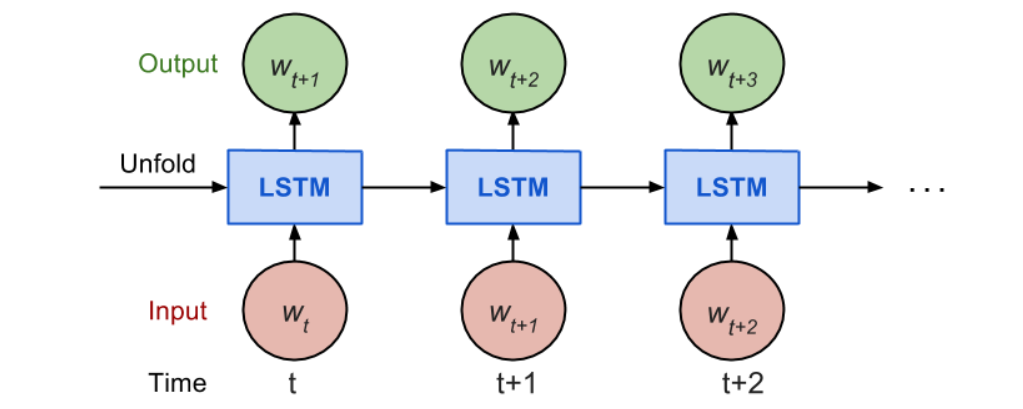


Unlike Feed-forward neural networks in which activation outputs are propagated only in one direction, the activation outputs from neurons propagate in both directions (from inputs to outputs and from outputs to inputs) in Recurrent Neural Networks. This creates loops in the neural network architecture which acts as a ‘memory state’ of the neurons. This state allows the neurons an ability to remember what have been learned so far.

The memory state in RNNs gives an advantage over traditional neural networks but a problem called Vanishing Gradient is associated with them. In this problem, while learning with a large number of layers, it becomes really hard for the network to learn and tune the parameters of the earlier layers. To address this problem, A new type of RNNs called LSTMs (Long Short Term Memory) Models have been developed.

LSTMs have an additional state called ‘cell state’ through which the network makes adjustments in the information flow. The advantage of this state is that the model can remember or forget the leanings more selectively. To learn more about LSTMs, here is a great post. Lets architecture a LSTM model in our code. I have added total three layers in the model.

Input Layer : Takes the sequence of words as input
LSTM Layer : Computes the output using LSTM units. I have added 100 units in the layer, but this number can be fine tuned later.
Dropout Layer : A regularisation layer which randomly turns-off the activations of some neurons in the LSTM layer. It helps in preventing over fitting. (Optional Layer)
Output Layer : Computes the probability of the best possible next word as output
We will run this model for total 100 epoochs but it can be experimented further.

In [9]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 18, 10)            24220     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2422)              244622    
Total params: 313,242
Trainable params: 313,242
Non-trainable params: 0
_________________________________________________________________


Lets train our model now

In [16]:
model.fit(predictors, label, epochs=100, verbose=5)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

### 5. Generating the text
Great, our model architecture is now ready and we can train it using our data. Next lets write the function to predict the next word based on the input words (or seed text). We will first tokenize the seed text, pad the sequences and pass into the trained model to get predicted word. The multiple predicted words can be appended together to get predicted sequence.

In [17]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

### 6. Result

In [21]:
print (generate_text("united states", 5, model, max_sequence_len))
print (generate_text("preident trump", 4, model, max_sequence_len))
print (generate_text("donald trump", 4, model, max_sequence_len))
print (generate_text("india and china", 4, model, max_sequence_len))
print (generate_text("new york", 4, model, max_sequence_len))
print (generate_text("science and technology", 5, model, max_sequence_len))

United States Governor Resigns And Pleads Guilty
Preident Trump Garbles Pitch On A
Donald Trump Riders A Brain Fog
India And China Deep Flavor Are Found
New York Today Sharing A Block
Science And Technology Shut From A Full Jet
